# SENTIMENT ANALYSIS USING BERT
BERT (Bidirectionnal Encoder Representations for Transformers)

### LIBRARIES IMPORT

In [68]:
!pip install transformers
!pip install symspellpy
!pip install contractions
!pip install sentencepiece

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from bs4 import BeautifulSoup
import contractions
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pkg_resources
from symspellpy import SymSpell, Verbosity
import re
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: No module named 'symspellpy'

### REVIEWS RETERIVEL FROM GOOGLE PLAY STORE REVIEWS DATASET

In [5]:
df = pd.read_csv('reviews.csv')

## DATA STATISTICS

In [71]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [72]:
df.shape

(12495, 12)

## COLUMN OF INTREST
We can see that the most relevant column for us is content and the score as well.

In [73]:
df = df[['content', 'score']].copy()
df.shape

(12495, 2)

## EXPLORATION

In [74]:
# Let's check for missing values 
df.isnull().sum()

content    0
score      0
dtype: int64

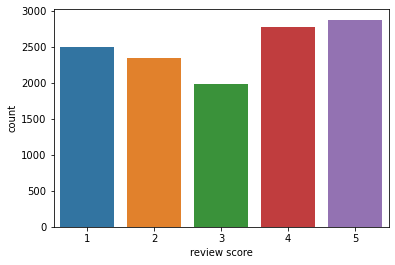

In [75]:
# Let's have a look at the class balance.
sns.countplot(df.score)
plt.xlabel('review score');

## REVIEW CONTENT CLEAINING AND PREPROCESSING

In [76]:
def pre_process_data(df,colmn_name):
    df[colmn_name] = df[colmn_name].str.lower()
    df[colmn_name] = df[colmn_name].apply(remove_html)
    df[colmn_name] = df[colmn_name].apply(contractions.fix)
    df[colmn_name] = df[colmn_name].apply(remove_urls)
    df[colmn_name] = df[colmn_name].apply(remove_emails)
    df[colmn_name] = df[colmn_name].apply(remove_mentions)
    df[colmn_name] = df[colmn_name].apply(remove_unicode_chars)
    df[colmn_name] = df[colmn_name].apply(remove_punctuations)
    df[colmn_name] =df[colmn_name].apply(remove_stopwords)
    df[colmn_name] =df[colmn_name].apply(remove_extra_spaces)
    df[colmn_name] =df[colmn_name].apply(lemmatize_text)
    return df
       
def correct_spelling_symspell_compound(text):
    bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
    sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
    words = [sym_spell.lookup_compound(word, max_edit_distance=2)[0].term for word in text.split()] 
    text = " ".join(words)
    return text
       
def correct_spelling_symspell(text):
    dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    words = [sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2,include_unknown=True)[0].term for word in text.split()] 
    text = " ".join(words)
    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(words)
    return text
       
def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text).strip()
    return text
       
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in stop_words])

def remove_digits(text):
    pattern = re.compile("\w*\d+\w*")
    text = re.sub(pattern, "",text)
    return text

def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), " ",text)
    return text

def remove_unicode_chars(text):
    text = text.encode("ascii", "ignore").decode()
    return text

def remove_mentions(text):
    pattern = re.compile(r"@\w+")
    text = re.sub(pattern, "", text)
    return text

def remove_emails(text):
    pattern = re.compile(r"[\w\.-]+@[\w\.-]+\.\w+")
    text = re.sub(pattern, "", text)
    return text

def remove_urls(text):
    pattern = re.compile(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?')
    text = re.sub(pattern, "", text)
    return text
    
def remove_html(text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    return text
    


In [77]:
df=pre_process_data(df,"content")
df

,content,score
0,cannot open app anymore,1
1,begging refund app month nobody replying,1
2,costly premium version approx indian rupee 910...,1
3,used keep organized 2020 update made mess thin...,1
4,dan birthday oct 28,1
...,...,...
12490,really like planner help achieve task goal ave...,5
12491,,5
12492,useful apps must try,5
12493,would pay even addition update absolutely love...,5


## RATING MAPPING TO DISTICT CLASSES (POSITIVE NEGATIVE AND NEUTRAL)

In our sentiment analysis task, we aim to assign appropriate sentiment classes to review ratings. We have defined three distinct classes to capture different sentiments:

**Positive Class** This class encompasses reviews that convey a positive sentiment towards the subject being reviewed. Reviews with ratings between 4 and 5 are classified as positive. These ratings indicate a high level of satisfaction or appreciation for the subject.

**Neutral Class** The neutral class represents reviews that exhibit a neutral sentiment. Reviews with a rating of 3 are categorized as neutral. Such ratings suggest a lack of strong positive or negative emotions, indicating a more balanced or indifferent viewpoint.

**Negative Class** This class includes reviews expressing a negative sentiment towards the subject. Ratings between 1 and 2 fall into the negative class. These ratings indicate disappointment, dissatisfaction, or criticism of the subject being reviewed.

In [78]:
# Function to convert score to sentiment
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2
# Apply to the dataset 
df['sentiment'] = df.score.apply(to_sentiment)

## PLOTTING THE UPDATED DISTRIBUTION

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

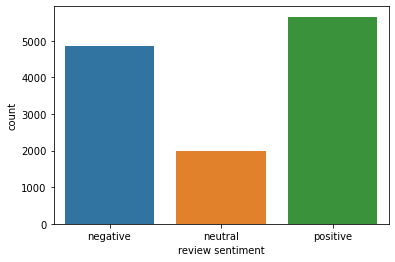

In [79]:
# Plot the distribution
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## DATA TOKENIZATION

In order to convert text into numerical representation for models like BERT, you need to tokenize the text. Tokenization is the process of breaking down the text into individual words or subwords, and assigning numerical values to each token.

For BERT, there are a few additional requirements to consider during tokenization:

**Special Tokens** BERT requires special tokens to separate sentences and perform classification tasks. These tokens include [CLS] (classification token) at the beginning of the input, [SEP] (separator token) to mark the end of a sentence or the separation between two sentences, and [PAD] (padding token) to make sequences of constant length. These tokens are added during tokenization.

**Padding** BERT expects sequences of constant length, so if a sentence is shorter than the maximum sequence length, it needs to be padded with [PAD] tokens. Padding ensures that all input sequences have the same length.

**Attention Mask** BERT also requires an attention mask, which is an array of 0s and 1s indicating which tokens are actual words and which ones are padding tokens. This mask helps BERT focus on the real tokens and ignore the padding tokens. The attention mask consists of 1s for real tokens and 0s for padding tokens.



## TOKENIZOR INSTANTIATION

In [80]:
MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

## FIXED LENGTH SEQEUENCE 

BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [81]:
# Store length of each review 
token_lens = []
for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

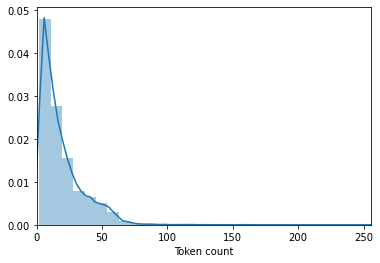

In [82]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

**Maximum Tokens**

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160. 

In [83]:
MAX_LEN = 160

## PYTORCH DATA SET CREATION

To effectively feed data into a PyTorch model, we need a powerful and versatile data generator class. This class goes beyond just supplying the required data by also including the review text. This additional feature greatly enhances the convenience and ease of validating our predictions. 

In [84]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

## DATASET SPLIITING

Create a 80% train data and 10% test and 10% validation data

In [85]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(9996, 3) (1249, 3) (1250, 3)


## DATALOADER INSTANTAITION

Create a dataloader to release data in batches.

In [86]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

## INSTANTAITING BERT MODEL FROM HUGGINGFACE 

To instantiate the BERT model from the Hugging Face library, we will use the basic BertModel and build our sentiment classifier on top of it. Let's proceed with loading the model.

In [87]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

## CUSTOM CLASSIFIER CLASS
We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU.

In [88]:
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

## INSTANTIATING AND TARINING

In [89]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [90]:
# Number of iterations 
EPOCHS = 1

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

## TRAINING LOOP

In [91]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

## EVALUATION

In [92]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

## EXECUTION

In [93]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/1
----------


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 0.7805997969627381 accuracy 0.6855742296918768
Val   loss 0.7046284598263004 accuracy 0.7213771016813451

CPU times: user 3min 23s, sys: 707 ms, total: 3min 24s
Wall time: 3min 25s


## TRAINING AND VALIDATION ACCURACY PLOT

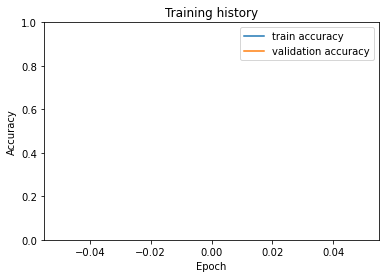

In [94]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### MODEL EVALUATION ON TEST DATA

In [95]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7056

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [96]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [97]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

## EVALUATION REPORT

**CLASSIFICATION REPORT**

In [98]:
bert_report=classification_report(y_test, y_pred, target_names=class_names)
print(bert_report)

              precision    recall  f1-score   support

    negative       0.68      0.84      0.75       480
     neutral       0.00      0.00      0.00       216
    positive       0.73      0.87      0.79       554

    accuracy                           0.71      1250
   macro avg       0.47      0.57      0.51      1250
weighted avg       0.58      0.71      0.64      1250



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**CONFUSION METRIX**

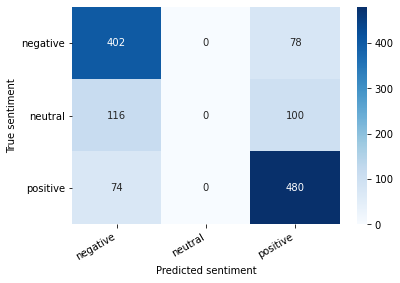

In [99]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## PREDICTION ON RAW DATA

In [100]:
review_text = "The application was compelely waste on time"

In [101]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [102]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: The application was compelely waste on time
Sentiment  : negative


## CONTEXTLESS ML MODELS TRAINING 

SVM, Random Forest, and BERT differ significantly in terms of their model architecture, handling of textual data, contextual understanding, transfer learning capabilities, and performance on sentiment analysis tasks.

SVM and Random Forest are traditional machine learning models that require manual feature engineering and transformation of text data into numerical representations. They focus on individual features and do not inherently capture contextual dependencies in text. While these models can perform well on sentiment analysis tasks with carefully engineered features, their performance may be limited by the lack of contextual understanding.

On the other hand, BERT, a transformer-based deep learning model, excels at capturing contextual information and relationships between words. It can handle raw text input directly, leveraging pre-training on large-scale corpora to learn rich language representations. BERT's ability to understand complex language patterns and contextual nuances makes it a powerful tool for sentiment analysis tasks.

By pre-processing the dataset, fine-tuning BERT, and utilizing optimization techniques such as mini-batch training and dropout regularization, we can further enhance the generalization capabilities of the model for sentiment analysis. Compared to SVM and Random Forest, BERT's deep learning architecture and pre-training on a large corpus of text data give it a distinct advantage in accurately predicting sentiment classes in the Google Play Store reviews dataset.

In summary, BERT offers a more advanced and effective approach to sentiment analysis compared to traditional machine learning models like SVM and Random Forest. Its ability to capture contextual dependencies and nuanced language patterns contributes to its superior performance and makes it a compelling choice for solving sentiment analysis problems.

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt

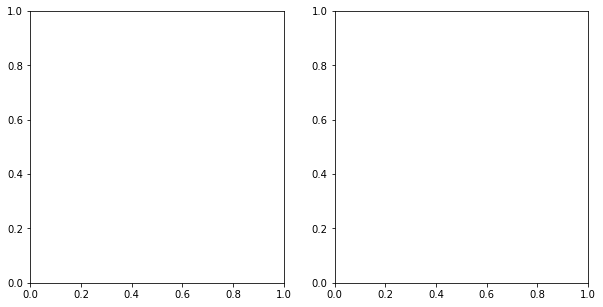

In [104]:
# Feature Extraction
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df["content"])
y = df["sentiment"]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plotting Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


## SVM TRAINING

In [105]:
# SVM Model
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)


**CLASSIFICATION REPORT**

In [106]:
print("SVM Classification Report:")
svm_report = classification_report(y_test, svm_predictions)
print(svm_report)

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.86      0.74       958
           1       0.43      0.02      0.04       421
           2       0.75      0.83      0.79      1120

    accuracy                           0.70      2499
   macro avg       0.61      0.57      0.52      2499
weighted avg       0.66      0.70      0.65      2499



## RANDOM FOREST TRAINING

In [107]:
# Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

**CLASSIFICATION REPORT**

In [108]:
print("Random Forest Classification Report:")
rf_report = classification_report(y_test, rf_predictions)
print(rf_report)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.82      0.73       958
           1       0.31      0.02      0.04       421
           2       0.74      0.83      0.78      1120

    accuracy                           0.69      2499
   macro avg       0.57      0.56      0.51      2499
weighted avg       0.63      0.69      0.63      2499



## CONFUSION MATRIX

In [109]:
# SVM Confusion Matrix
svm_disp = plot_confusion_matrix(svm_model, X_test, y_test, ax=axes[0])
svm_disp.ax_.set_title('SVM Confusion Matrix')

# Random Forest Confusion Matrix
rf_disp = plot_confusion_matrix(rf_model, X_test, y_test, ax=axes[1])
rf_disp.ax_.set_title('Random Forest Confusion Matrix')

plt.show()

## PREDICTION ON RAW DATA

In [110]:
# Example prediction
example_text = "This app is amazing!"
example_vector = tfidf_vectorizer.transform([example_text])

svm_prediction = svm_model.predict(example_vector)
rf_prediction = rf_model.predict(example_vector)

print("Example Text:", example_text)
print("SVM Prediction:",class_names[svm_prediction[0]] )
print("Random Forest Prediction:",class_names[ rf_prediction[0]])

Example Text: This app is amazing!
SVM Prediction: positive
Random Forest Prediction: positive


## END